In [ ]:
# Foundation
import os
import gc
import json
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Audio
import torchaudio
import librosa
import soundfile as sf

# Transformers
from transformers import AutoTokenizer, ClapModel, AutoFeatureExtractor

# Split
from sklearn.model_selection import train_test_split

# Warnings
warnings.filterwarnings("ignore")

# SEED
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
import wandb

def initialize_wandb(project_name="emotion-recognition", config=None):
    if config is None:
        config = {
            "architecture": "EmotionMLP",
            "dataset": "CLAP_features",
            "learning_rate": LEARNING_RATE,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "optimizer": "Adam",
            "loss_function": "BCELoss",
        }

    wandb.init(project=project_name, config=config)

# Model & Dataset

In [ ]:
class EmotionMLP(torch.nn.Module):
    def __init__(self, input_size=1024, hidden_size=256):
        super(EmotionMLP, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_size)
        self.relu1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(0.3)

        self.linear2 = torch.nn.Linear(hidden_size, 128)
        self.batch_norm2 = torch.nn.BatchNorm1d(128)
        self.relu2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(0.3)
        self.linear3 = torch.nn.Linear(128, 8)

    def forward(self, x):
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.linear3(x)
        probabilities = torch.sigmoid(x)
        return probabilities

class EmotionDataset(Dataset):
    def __init__(self, df, audio_dir, tokenizer, feature_extractor, clap_model):
        self.df = df
        self.audio_dir = audio_dir
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.clap_model = clap_model
        self.emotion_columns = EMOTIONS

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row['filename']
        text = row['text']

        emotion_probs = torch.tensor([float(row[emotion]) for emotion in self.emotion_columns],
                                    dtype=torch.float32)

        audio_path = os.path.join(self.audio_dir, filename)
        wav, sampling_rate = torchaudio.load(audio_path)
        wav_numpy = wav.squeeze().cpu().numpy()

        resampled_numpy = librosa.resample(
            y=wav_numpy,
            orig_sr=sampling_rate,
            target_sr=48000
        )

        inputs_text = self.tokenizer([text], padding=True, return_tensors="pt")
        inputs_audio = self.feature_extractor(resampled_numpy, sampling_rate=48000, return_tensors="pt")

        for key in inputs_text:
            inputs_text[key] = inputs_text[key].to(DEVICE)
        for key in inputs_audio:
            inputs_audio[key] = inputs_audio[key].to(DEVICE)

        with torch.no_grad():
            text_features = self.clap_model.get_text_features(**inputs_text)
            audio_features = self.clap_model.get_audio_features(**inputs_audio)[0].unsqueeze(0)

        concatenated_features = torch.cat((text_features, audio_features), dim=1).squeeze(0)

        return concatenated_features, emotion_probs

# Training & Test

In [ ]:
def calculate_f1_score(predictions, targets, threshold=0.5):
    binary_preds = (predictions > threshold).float()
    true_positives = (binary_preds * targets).sum(dim=0)
    false_positives = (binary_preds * (1 - targets)).sum(dim=0)
    false_negatives = ((1 - binary_preds) * targets).sum(dim=0)
    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1.mean().item()

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, use_wandb=True):
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    best_val_loss = float('inf')
    best_model_state = None

    if use_wandb:
        wandb.watch(model, criterion, log="all", log_freq=10)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_targets = []

        for features, targets in tqdm(train_loader, desc=f"에포크 {epoch+1}/{num_epochs} - 학습"):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(features)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)
            all_preds.append(outputs.detach().cpu())
            all_targets.append(targets.cpu())

        train_loss = running_loss / len(train_loader.dataset)
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        train_f1 = calculate_f1_score(all_preds, all_targets)

        train_precision, train_recall = calculate_precision_recall(all_preds, all_targets)

        train_losses.append(train_loss)
        train_f1_scores.append(train_f1)

        model.eval()
        running_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for features, targets in tqdm(val_loader, desc=f"에포크 {epoch+1}/{num_epochs} - 검증"):
                features = features.to(DEVICE)
                targets = targets.to(DEVICE)

                outputs = model(features)
                loss = criterion(outputs, targets)

                running_loss += loss.item() * features.size(0)
                all_preds.append(outputs.cpu())
                all_targets.append(targets.cpu())

        val_loss = running_loss / len(val_loader.dataset)
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        val_f1 = calculate_f1_score(all_preds, all_targets)

        val_precision, val_recall = calculate_precision_recall(all_preds, all_targets)

        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)

        emotion_f1_scores = calculate_per_emotion_f1(all_preds, all_targets, emotions=EMOTIONS)

        print(f"에포크 {epoch+1}/{num_epochs}: "
              f"학습 손실: {train_loss:.4f}, 학습 F1: {train_f1:.4f}, "
              f"검증 손실: {val_loss:.4f}, 검증 F1: {val_f1:.4f}")

        if use_wandb:
            log_dict = {
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_f1": train_f1,
                "train_precision": train_precision,
                "train_recall": train_recall,
                "val_loss": val_loss,
                "val_f1": val_f1,
                "val_precision": val_precision,
                "val_recall": val_recall,
            }

            for emotion, score in emotion_f1_scores.items():
                log_dict[f"val_f1_{emotion}"] = score

            wandb.log(log_dict)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print(f"검증 손실 {val_loss:.4f}로 새로운 최고 모델이 저장되었습니다")
            torch.save(best_model_state, 'best_emotion_model.pth')

            if use_wandb:
                wandb.save('best_emotion_model.pth')

        if (epoch + 1) % 5 == 0:
            checkpoint_path = f'emotion_model_checkpoint_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, checkpoint_path)

            if use_wandb:
                wandb.save(checkpoint_path)

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    model.load_state_dict(best_model_state)

    if use_wandb:
        wandb.finish()

    return model, train_losses, val_losses, train_f1_scores, val_f1_scores

def calculate_precision_recall(predictions, targets, threshold=0.5):
    binary_preds = (predictions > threshold).float()

    true_positives = (binary_preds * targets).sum(dim=0)
    false_positives = (binary_preds * (1 - targets)).sum(dim=0)
    false_negatives = ((1 - binary_preds) * targets).sum(dim=0)

    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)

    return precision.mean().item(), recall.mean().item()

def calculate_per_emotion_f1(predictions, targets, emotions, threshold=0.5):
    binary_preds = (predictions > threshold).float()

    emotion_f1 = {}
    for i, emotion in enumerate(emotions):
        true_positives = (binary_preds[:, i] * targets[:, i]).sum()
        false_positives = (binary_preds[:, i] * (1 - targets[:, i])).sum()
        false_negatives = ((1 - binary_preds[:, i]) * targets[:, i]).sum()

        precision = true_positives / (true_positives + false_positives + 1e-8)
        recall = true_positives / (true_positives + false_negatives + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

        emotion_f1[emotion] = f1.item()

    return emotion_f1

def plot_training_results(train_losses, val_losses, train_f1_scores, val_f1_scores):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1_scores, label='Training F1 Score')
    plt.plot(val_f1_scores, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()

def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for features, targets in tqdm(test_loader, desc="테스트 중"):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            outputs = model(features)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * features.size(0)
            all_preds.append(outputs.cpu())
            all_targets.append(targets.cpu())

    test_loss = running_loss / len(test_loader.dataset)
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    test_f1 = calculate_f1_score(all_preds, all_targets)

    print(f"테스트 손실: {test_loss:.4f}, 테스트 F1: {test_f1:.4f}")

    threshold = 0.5
    binary_preds = (all_preds > threshold).float()

    for i, emotion in enumerate(EMOTIONS):
        emotion_preds = binary_preds[:, i]
        emotion_targets = all_targets[:, i]

        true_positives = (emotion_preds * emotion_targets).sum().item()
        false_positives = (emotion_preds * (1 - emotion_targets)).sum().item()
        false_negatives = ((1 - emotion_preds) * emotion_targets).sum().item()

        precision = true_positives / (true_positives + false_positives + 1e-8)
        recall = true_positives / (true_positives + false_negatives + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

        total_positive = emotion_targets.sum().item()
        percentage = (total_positive / len(emotion_targets)) * 100

        print(f"{emotion}: 정밀도 = {precision:.4f}, 재현율 = {recall:.4f}, F1 = {f1:.4f}, 데이터셋 비율 = {percentage:.2f}%")

    return test_loss, test_f1, all_preds, all_targets

In [ ]:
EMOTIONS = ['Happiness', 'Sadness', 'Disgust', 'Fear', 'Surprise', 'Anger', 'Other', 'Neutral']
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.0001
AUDIO_DIR = '/content/a/'
CSV_PATH = '/content/a/vocals_with_emotions (1).csv'

def initialize_models():
    clap_model = ClapModel.from_pretrained("laion/larger_clap_general")
    feature_extractor = AutoFeatureExtractor.from_pretrained("laion/larger_clap_general")
    tokenizer = AutoTokenizer.from_pretrained("laion/larger_clap_general")
    clap_model.eval()

    clap_model = clap_model.to(DEVICE)

    input_size = 1024
    mlp_model = EmotionMLP(input_size=input_size).to(DEVICE)

    return clap_model, feature_extractor, tokenizer, mlp_model

def split_with_rare_label_preservation(df, test_size=0.05, val_size=0.05, rare_threshold=5, random_state=42):
    emotion_cols = ['Happiness', 'Sadness', 'Disgust', 'Fear', 'Surprise', 'Anger', 'Other', 'Neutral']

    df['emotion_combination'] = ''
    for i, row in df.iterrows():
        present_emotions = [emotion for emotion in emotion_cols if row[emotion] == 1]
        present_emotions.sort()
        df.at[i, 'emotion_combination'] = '+'.join(present_emotions) if present_emotions else 'None'

    combination_counts = df['emotion_combination'].value_counts()
    rare_combinations = combination_counts[combination_counts <= rare_threshold].index.tolist()

    rare_df = df[df['emotion_combination'].isin(rare_combinations)].copy()
    common_df = df[~df['emotion_combination'].isin(rare_combinations)].copy()

    print(f"희소 라벨 조합: {len(rare_combinations)}개, 총 {len(rare_df)}개 샘플")
    print(f"일반 샘플: {len(common_df)}개")

    common_train_val, common_test = train_test_split(
        common_df, test_size=test_size, random_state=random_state,
        stratify=common_df['emotion_combination'] if not common_df.empty else None
    )

    common_train, common_val = train_test_split(
        common_train_val, test_size=val_size/(1-test_size), random_state=random_state,
        stratify=common_train_val['emotion_combination'] if not common_train_val.empty else None
    )

    if not rare_df.empty:
        train_df = pd.concat([common_train, rare_df]).reset_index(drop=True)
        val_df = pd.concat([common_val, rare_df]).reset_index(drop=True)
        test_df = pd.concat([common_test, rare_df]).reset_index(drop=True)
    else:
        train_df = common_train
        val_df = common_val
        test_df = common_test

    train_df = train_df.drop(columns=['emotion_combination'])
    val_df = val_df.drop(columns=['emotion_combination'])
    test_df = test_df.drop(columns=['emotion_combination'])
    return train_df, val_df, test_df

df = pd.read_csv(CSV_PATH)
df = df[~df['primary_emotion'].isna()]
clap_model, feature_extractor, tokenizer, mlp_model = initialize_models()
train_df, val_df, test_df = split_with_rare_label_preservation(df, rare_threshold=3)

train_dataset = EmotionDataset(train_df, AUDIO_DIR, tokenizer, feature_extractor, clap_model)
val_dataset = EmotionDataset(val_df, AUDIO_DIR, tokenizer, feature_extractor, clap_model)
test_dataset = EmotionDataset(test_df, AUDIO_DIR, tokenizer, feature_extractor, clap_model)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

희소 라벨 조합: 19개, 총 31개 샘플
일반 샘플: 630개


In [ ]:
config = {
    "architecture": "EmotionMLP",
    "dataset": "vocals_segments",
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "epochs": EPOCHS,
    "optimizer": "Adam",
    "weight_decay": 1e-5,
    "hidden_size": 128,
    "dropout_rate": 0.5,
    "num_train_samples": len(train_df),
    "num_val_samples": len(val_df),
    "num_test_samples": len(test_df),
    "emotion_distribution": {emotion: int(df[emotion].sum()) for emotion in EMOTIONS}
}
initialize_wandb(project_name="emotion-recognition", config=config)

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: withop9974 (withop9974-hansung-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


에포크 1/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


에포크 1/100: 학습 손실: 0.6653, 학습 F1: 0.2372, 검증 손실: 0.6781, 검증 F1: 0.1508
검증 손실 0.6781로 새로운 최고 모델이 저장되었습니다


에포크 2/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


에포크 2/100: 학습 손실: 0.6105, 학습 F1: 0.2795, 검증 손실: 0.6288, 검증 F1: 0.3611
검증 손실 0.6288로 새로운 최고 모델이 저장되었습니다


에포크 3/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


에포크 3/100: 학습 손실: 0.5663, 학습 F1: 0.2882, 검증 손실: 0.5843, 검증 F1: 0.3795
검증 손실 0.5843로 새로운 최고 모델이 저장되었습니다


에포크 4/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


에포크 4/100: 학습 손실: 0.5296, 학습 F1: 0.3027, 검증 손실: 0.5626, 검증 F1: 0.3724
검증 손실 0.5626로 새로운 최고 모델이 저장되었습니다


에포크 5/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


에포크 5/100: 학습 손실: 0.5040, 학습 F1: 0.2920, 검증 손실: 0.5445, 검증 F1: 0.2919
검증 손실 0.5445로 새로운 최고 모델이 저장되었습니다


에포크 6/100 - 검증: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


에포크 6/100: 학습 손실: 0.4838, 학습 F1: 0.2882, 검증 손실: 0.5322, 검증 F1: 0.2636
검증 손실 0.5322로 새로운 최고 모델이 저장되었습니다


에포크 7/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


에포크 7/100: 학습 손실: 0.4651, 학습 F1: 0.2743, 검증 손실: 0.5220, 검증 F1: 0.2742
검증 손실 0.5220로 새로운 최고 모델이 저장되었습니다


에포크 8/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


에포크 8/100: 학습 손실: 0.4439, 학습 F1: 0.2848, 검증 손실: 0.5177, 검증 F1: 0.2794
검증 손실 0.5177로 새로운 최고 모델이 저장되었습니다


에포크 9/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


에포크 9/100: 학습 손실: 0.4315, 학습 F1: 0.3056, 검증 손실: 0.5067, 검증 F1: 0.2720
검증 손실 0.5067로 새로운 최고 모델이 저장되었습니다


에포크 10/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


에포크 10/100: 학습 손실: 0.4176, 학습 F1: 0.2795, 검증 손실: 0.4983, 검증 F1: 0.2634
검증 손실 0.4983로 새로운 최고 모델이 저장되었습니다


에포크 11/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


에포크 11/100: 학습 손실: 0.4047, 학습 F1: 0.2854, 검증 손실: 0.4908, 검증 F1: 0.2841
검증 손실 0.4908로 새로운 최고 모델이 저장되었습니다


에포크 12/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


에포크 12/100: 학습 손실: 0.3973, 학습 F1: 0.2769, 검증 손실: 0.4858, 검증 F1: 0.2751
검증 손실 0.4858로 새로운 최고 모델이 저장되었습니다


에포크 13/100 - 검증: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


에포크 13/100: 학습 손실: 0.3870, 학습 F1: 0.3038, 검증 손실: 0.4780, 검증 F1: 0.3048
검증 손실 0.4780로 새로운 최고 모델이 저장되었습니다


에포크 14/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


에포크 14/100: 학습 손실: 0.3778, 학습 F1: 0.3385, 검증 손실: 0.4741, 검증 F1: 0.2933
검증 손실 0.4741로 새로운 최고 모델이 저장되었습니다


에포크 15/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


에포크 15/100: 학습 손실: 0.3697, 학습 F1: 0.3431, 검증 손실: 0.4684, 검증 F1: 0.2985
검증 손실 0.4684로 새로운 최고 모델이 저장되었습니다


에포크 16/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


에포크 16/100: 학습 손실: 0.3643, 학습 F1: 0.3128, 검증 손실: 0.4595, 검증 F1: 0.3362
검증 손실 0.4595로 새로운 최고 모델이 저장되었습니다


에포크 17/100 - 검증: 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


에포크 17/100: 학습 손실: 0.3537, 학습 F1: 0.3557, 검증 손실: 0.4553, 검증 F1: 0.3441
검증 손실 0.4553로 새로운 최고 모델이 저장되었습니다


에포크 18/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


에포크 18/100: 학습 손실: 0.3397, 학습 F1: 0.3839, 검증 손실: 0.4539, 검증 F1: 0.3819
검증 손실 0.4539로 새로운 최고 모델이 저장되었습니다


에포크 19/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


에포크 19/100: 학습 손실: 0.3370, 학습 F1: 0.4158, 검증 손실: 0.4497, 검증 F1: 0.3818
검증 손실 0.4497로 새로운 최고 모델이 저장되었습니다


에포크 20/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


에포크 20/100: 학습 손실: 0.3288, 학습 F1: 0.4013, 검증 손실: 0.4475, 검증 F1: 0.4082
검증 손실 0.4475로 새로운 최고 모델이 저장되었습니다


에포크 21/100 - 검증: 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


에포크 21/100: 학습 손실: 0.3222, 학습 F1: 0.4221, 검증 손실: 0.4404, 검증 F1: 0.4227
검증 손실 0.4404로 새로운 최고 모델이 저장되었습니다


에포크 22/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


에포크 22/100: 학습 손실: 0.3146, 학습 F1: 0.4643, 검증 손실: 0.4368, 검증 F1: 0.4364
검증 손실 0.4368로 새로운 최고 모델이 저장되었습니다


에포크 23/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


에포크 23/100: 학습 손실: 0.3153, 학습 F1: 0.4521, 검증 손실: 0.4306, 검증 F1: 0.4816
검증 손실 0.4306로 새로운 최고 모델이 저장되었습니다


에포크 24/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


에포크 24/100: 학습 손실: 0.3070, 학습 F1: 0.4769, 검증 손실: 0.4333, 검증 F1: 0.4669


에포크 25/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


에포크 25/100: 학습 손실: 0.2953, 학습 F1: 0.5234, 검증 손실: 0.4247, 검증 F1: 0.4713
검증 손실 0.4247로 새로운 최고 모델이 저장되었습니다


에포크 26/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


에포크 26/100: 학습 손실: 0.2904, 학습 F1: 0.5132, 검증 손실: 0.4197, 검증 F1: 0.5040
검증 손실 0.4197로 새로운 최고 모델이 저장되었습니다


에포크 27/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


에포크 27/100: 학습 손실: 0.2836, 학습 F1: 0.5402, 검증 손실: 0.4184, 검증 F1: 0.4961
검증 손실 0.4184로 새로운 최고 모델이 저장되었습니다


에포크 28/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


에포크 28/100: 학습 손실: 0.2745, 학습 F1: 0.5725, 검증 손실: 0.4115, 검증 F1: 0.5374
검증 손실 0.4115로 새로운 최고 모델이 저장되었습니다


에포크 29/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


에포크 29/100: 학습 손실: 0.2694, 학습 F1: 0.5838, 검증 손실: 0.4086, 검증 F1: 0.5531
검증 손실 0.4086로 새로운 최고 모델이 저장되었습니다


에포크 30/100 - 검증: 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


에포크 30/100: 학습 손실: 0.2619, 학습 F1: 0.6156, 검증 손실: 0.4087, 검증 F1: 0.5178


에포크 31/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


에포크 31/100: 학습 손실: 0.2568, 학습 F1: 0.6133, 검증 손실: 0.4034, 검증 F1: 0.5645
검증 손실 0.4034로 새로운 최고 모델이 저장되었습니다


에포크 32/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


에포크 32/100: 학습 손실: 0.2530, 학습 F1: 0.6183, 검증 손실: 0.3978, 검증 F1: 0.5611
검증 손실 0.3978로 새로운 최고 모델이 저장되었습니다


에포크 33/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


에포크 33/100: 학습 손실: 0.2445, 학습 F1: 0.6679, 검증 손실: 0.4011, 검증 F1: 0.5366


에포크 34/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


에포크 34/100: 학습 손실: 0.2375, 학습 F1: 0.6795, 검증 손실: 0.3970, 검증 F1: 0.5478
검증 손실 0.3970로 새로운 최고 모델이 저장되었습니다


에포크 35/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


에포크 35/100: 학습 손실: 0.2388, 학습 F1: 0.6689, 검증 손실: 0.3945, 검증 F1: 0.5606
검증 손실 0.3945로 새로운 최고 모델이 저장되었습니다


에포크 36/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


에포크 36/100: 학습 손실: 0.2309, 학습 F1: 0.6885, 검증 손실: 0.3946, 검증 F1: 0.5690


에포크 37/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


에포크 37/100: 학습 손실: 0.2229, 학습 F1: 0.7068, 검증 손실: 0.3881, 검증 F1: 0.5790
검증 손실 0.3881로 새로운 최고 모델이 저장되었습니다


에포크 38/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


에포크 38/100: 학습 손실: 0.2174, 학습 F1: 0.7169, 검증 손실: 0.3827, 검증 F1: 0.5671
검증 손실 0.3827로 새로운 최고 모델이 저장되었습니다


에포크 39/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


에포크 39/100: 학습 손실: 0.2164, 학습 F1: 0.7043, 검증 손실: 0.3781, 검증 F1: 0.5959
검증 손실 0.3781로 새로운 최고 모델이 저장되었습니다


에포크 40/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


에포크 40/100: 학습 손실: 0.2052, 학습 F1: 0.7490, 검증 손실: 0.3731, 검증 F1: 0.6235
검증 손실 0.3731로 새로운 최고 모델이 저장되었습니다


에포크 41/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


에포크 41/100: 학습 손실: 0.2111, 학습 F1: 0.7270, 검증 손실: 0.3714, 검증 F1: 0.6311
검증 손실 0.3714로 새로운 최고 모델이 저장되었습니다


에포크 42/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


에포크 42/100: 학습 손실: 0.2013, 학습 F1: 0.7778, 검증 손실: 0.3718, 검증 F1: 0.6185


에포크 43/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


에포크 43/100: 학습 손실: 0.1949, 학습 F1: 0.7844, 검증 손실: 0.3649, 검증 F1: 0.6676
검증 손실 0.3649로 새로운 최고 모델이 저장되었습니다


에포크 44/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


에포크 44/100: 학습 손실: 0.1931, 학습 F1: 0.7782, 검증 손실: 0.3664, 검증 F1: 0.6346


에포크 45/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


에포크 45/100: 학습 손실: 0.1860, 학습 F1: 0.7800, 검증 손실: 0.3662, 검증 F1: 0.6572


에포크 46/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


에포크 46/100: 학습 손실: 0.1760, 학습 F1: 0.8304, 검증 손실: 0.3624, 검증 F1: 0.6676
검증 손실 0.3624로 새로운 최고 모델이 저장되었습니다


에포크 47/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


에포크 47/100: 학습 손실: 0.1805, 학습 F1: 0.8134, 검증 손실: 0.3583, 검증 F1: 0.6937
검증 손실 0.3583로 새로운 최고 모델이 저장되었습니다


에포크 48/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


에포크 48/100: 학습 손실: 0.1760, 학습 F1: 0.8084, 검증 손실: 0.3533, 검증 F1: 0.7011
검증 손실 0.3533로 새로운 최고 모델이 저장되었습니다


에포크 49/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


에포크 49/100: 학습 손실: 0.1731, 학습 F1: 0.8313, 검증 손실: 0.3529, 검증 F1: 0.6893
검증 손실 0.3529로 새로운 최고 모델이 저장되었습니다


에포크 50/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


에포크 50/100: 학습 손실: 0.1653, 학습 F1: 0.8294, 검증 손실: 0.3491, 검증 F1: 0.6924
검증 손실 0.3491로 새로운 최고 모델이 저장되었습니다


에포크 51/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


에포크 51/100: 학습 손실: 0.1613, 학습 F1: 0.8413, 검증 손실: 0.3413, 검증 F1: 0.7191
검증 손실 0.3413로 새로운 최고 모델이 저장되었습니다


에포크 52/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


에포크 52/100: 학습 손실: 0.1630, 학습 F1: 0.8579, 검증 손실: 0.3436, 검증 F1: 0.7201


에포크 53/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


에포크 53/100: 학습 손실: 0.1478, 학습 F1: 0.8731, 검증 손실: 0.3413, 검증 F1: 0.7280


에포크 54/100 - 검증: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


에포크 54/100: 학습 손실: 0.1534, 학습 F1: 0.8631, 검증 손실: 0.3430, 검증 F1: 0.7409


에포크 55/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


에포크 55/100: 학습 손실: 0.1489, 학습 F1: 0.8735, 검증 손실: 0.3430, 검증 F1: 0.7488


에포크 56/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


에포크 56/100: 학습 손실: 0.1477, 학습 F1: 0.8694, 검증 손실: 0.3380, 검증 F1: 0.7573
검증 손실 0.3380로 새로운 최고 모델이 저장되었습니다


에포크 57/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


에포크 57/100: 학습 손실: 0.1458, 학습 F1: 0.8898, 검증 손실: 0.3270, 검증 F1: 0.7427
검증 손실 0.3270로 새로운 최고 모델이 저장되었습니다


에포크 58/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


에포크 58/100: 학습 손실: 0.1399, 학습 F1: 0.8963, 검증 손실: 0.3313, 검증 F1: 0.7592


에포크 59/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


에포크 59/100: 학습 손실: 0.1318, 학습 F1: 0.9024, 검증 손실: 0.3358, 검증 F1: 0.7612


에포크 60/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


에포크 60/100: 학습 손실: 0.1364, 학습 F1: 0.9020, 검증 손실: 0.3419, 검증 F1: 0.7571


에포크 61/100 - 검증: 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


에포크 61/100: 학습 손실: 0.1298, 학습 F1: 0.8889, 검증 손실: 0.3319, 검증 F1: 0.7654


에포크 62/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


에포크 62/100: 학습 손실: 0.1318, 학습 F1: 0.8929, 검증 손실: 0.3476, 검증 F1: 0.7220


에포크 63/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


에포크 63/100: 학습 손실: 0.1266, 학습 F1: 0.9157, 검증 손실: 0.3434, 검증 F1: 0.7579


에포크 64/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


에포크 64/100: 학습 손실: 0.1250, 학습 F1: 0.9089, 검증 손실: 0.3310, 검증 F1: 0.7556


에포크 65/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


에포크 65/100: 학습 손실: 0.1231, 학습 F1: 0.9125, 검증 손실: 0.3370, 검증 F1: 0.7763


에포크 66/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


에포크 66/100: 학습 손실: 0.1242, 학습 F1: 0.9022, 검증 손실: 0.3238, 검증 F1: 0.7500
검증 손실 0.3238로 새로운 최고 모델이 저장되었습니다


에포크 67/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


에포크 67/100: 학습 손실: 0.1272, 학습 F1: 0.8919, 검증 손실: 0.3341, 검증 F1: 0.7702


에포크 68/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


에포크 68/100: 학습 손실: 0.1170, 학습 F1: 0.9225, 검증 손실: 0.3300, 검증 F1: 0.7719


에포크 69/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


에포크 69/100: 학습 손실: 0.1125, 학습 F1: 0.9207, 검증 손실: 0.3337, 검증 F1: 0.7680


에포크 70/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


에포크 70/100: 학습 손실: 0.1135, 학습 F1: 0.9166, 검증 손실: 0.3173, 검증 F1: 0.7624
검증 손실 0.3173로 새로운 최고 모델이 저장되었습니다


에포크 71/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


에포크 71/100: 학습 손실: 0.1104, 학습 F1: 0.9255, 검증 손실: 0.3205, 검증 F1: 0.7703


에포크 72/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


에포크 72/100: 학습 손실: 0.1128, 학습 F1: 0.9200, 검증 손실: 0.3250, 검증 F1: 0.7541


에포크 73/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


에포크 73/100: 학습 손실: 0.1129, 학습 F1: 0.9217, 검증 손실: 0.3246, 검증 F1: 0.7793


에포크 74/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


에포크 74/100: 학습 손실: 0.1030, 학습 F1: 0.9377, 검증 손실: 0.3371, 검증 F1: 0.7668


에포크 75/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


에포크 75/100: 학습 손실: 0.1066, 학습 F1: 0.9240, 검증 손실: 0.3315, 검증 F1: 0.7308


에포크 76/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


에포크 76/100: 학습 손실: 0.0997, 학습 F1: 0.9388, 검증 손실: 0.3193, 검증 F1: 0.7829


에포크 77/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


에포크 77/100: 학습 손실: 0.1023, 학습 F1: 0.9376, 검증 손실: 0.3328, 검증 F1: 0.7709


에포크 78/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


에포크 78/100: 학습 손실: 0.0958, 학습 F1: 0.9396, 검증 손실: 0.3386, 검증 F1: 0.7526


에포크 79/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


에포크 79/100: 학습 손실: 0.0972, 학습 F1: 0.9334, 검증 손실: 0.3257, 검증 F1: 0.7619


에포크 80/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


에포크 80/100: 학습 손실: 0.0981, 학습 F1: 0.9445, 검증 손실: 0.3203, 검증 F1: 0.7829


에포크 81/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


에포크 81/100: 학습 손실: 0.0960, 학습 F1: 0.9403, 검증 손실: 0.3172, 검증 F1: 0.7750
검증 손실 0.3172로 새로운 최고 모델이 저장되었습니다


에포크 82/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


에포크 82/100: 학습 손실: 0.0887, 학습 F1: 0.9424, 검증 손실: 0.3243, 검증 F1: 0.7914


에포크 83/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


에포크 83/100: 학습 손실: 0.0916, 학습 F1: 0.9366, 검증 손실: 0.3162, 검증 F1: 0.7754
검증 손실 0.3162로 새로운 최고 모델이 저장되었습니다


에포크 84/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


에포크 84/100: 학습 손실: 0.0859, 학습 F1: 0.9494, 검증 손실: 0.3183, 검증 F1: 0.7841


에포크 85/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


에포크 85/100: 학습 손실: 0.0906, 학습 F1: 0.9455, 검증 손실: 0.3173, 검증 F1: 0.7869


에포크 86/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


에포크 86/100: 학습 손실: 0.0880, 학습 F1: 0.9486, 검증 손실: 0.3166, 검증 F1: 0.7651


에포크 87/100 - 검증: 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


에포크 87/100: 학습 손실: 0.0932, 학습 F1: 0.9380, 검증 손실: 0.3226, 검증 F1: 0.7774


에포크 88/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


에포크 88/100: 학습 손실: 0.0856, 학습 F1: 0.9487, 검증 손실: 0.3165, 검증 F1: 0.7661


에포크 89/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


에포크 89/100: 학습 손실: 0.0836, 학습 F1: 0.9532, 검증 손실: 0.3203, 검증 F1: 0.7784


에포크 90/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


에포크 90/100: 학습 손실: 0.0811, 학습 F1: 0.9460, 검증 손실: 0.3274, 검증 F1: 0.7775


에포크 91/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


에포크 91/100: 학습 손실: 0.0843, 학습 F1: 0.9410, 검증 손실: 0.3223, 검증 F1: 0.7590


에포크 92/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


에포크 92/100: 학습 손실: 0.0792, 학습 F1: 0.9578, 검증 손실: 0.3108, 검증 F1: 0.7661
검증 손실 0.3108로 새로운 최고 모델이 저장되었습니다


에포크 93/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


에포크 93/100: 학습 손실: 0.0816, 학습 F1: 0.9460, 검증 손실: 0.3159, 검증 F1: 0.7697


에포크 94/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


에포크 94/100: 학습 손실: 0.0824, 학습 F1: 0.9492, 검증 손실: 0.3128, 검증 F1: 0.7781


에포크 95/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


에포크 95/100: 학습 손실: 0.0793, 학습 F1: 0.9578, 검증 손실: 0.3242, 검증 F1: 0.7740


에포크 96/100 - 검증: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


에포크 96/100: 학습 손실: 0.0776, 학습 F1: 0.9590, 검증 손실: 0.3308, 검증 F1: 0.7378


에포크 97/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


에포크 97/100: 학습 손실: 0.0757, 학습 F1: 0.9558, 검증 손실: 0.3198, 검증 F1: 0.7513


에포크 98/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


에포크 98/100: 학습 손실: 0.0760, 학습 F1: 0.9572, 검증 손실: 0.3253, 검증 F1: 0.7776


에포크 99/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


에포크 99/100: 학습 손실: 0.0733, 학습 F1: 0.9578, 검증 손실: 0.3141, 검증 F1: 0.7813


에포크 100/100 - 검증: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


에포크 100/100: 학습 손실: 0.0764, 학습 F1: 0.9626, 검증 손실: 0.3032, 검증 F1: 0.7922
검증 손실 0.3032로 새로운 최고 모델이 저장되었습니다


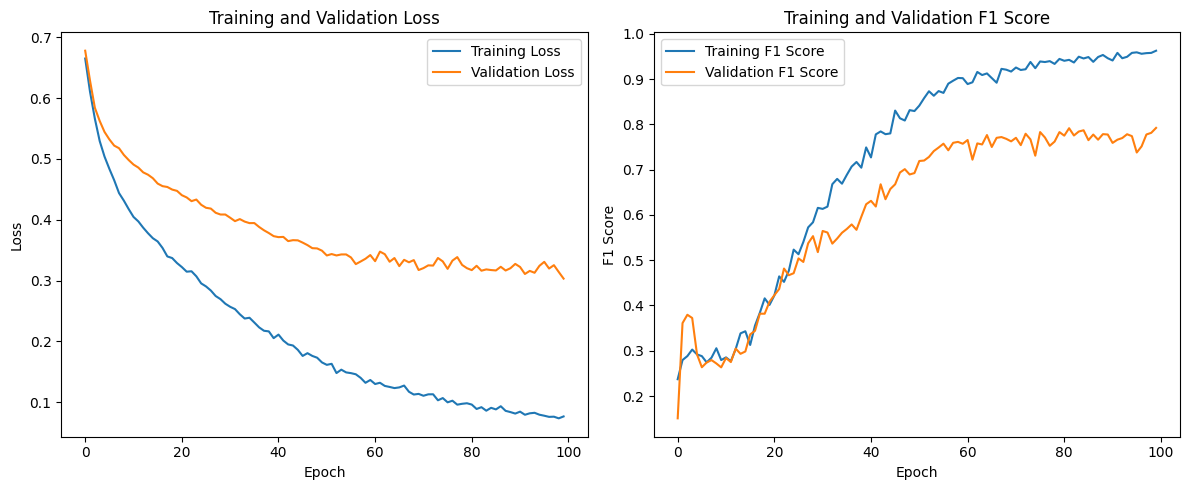

테스트 중: 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]

테스트 손실: 0.3619, 테스트 F1: 0.7555
Happiness: 정밀도 = 0.5714, 재현율 = 0.5000, F1 = 0.5333, 데이터셋 비율 = 12.70%
Sadness: 정밀도 = 1.0000, 재현율 = 0.9412, F1 = 0.9697, 데이터셋 비율 = 26.98%
Disgust: 정밀도 = 0.9333, 재현율 = 0.9333, F1 = 0.9333, 데이터셋 비율 = 23.81%
Fear: 정밀도 = 0.9444, 재현율 = 0.8095, F1 = 0.8718, 데이터셋 비율 = 33.33%
Surprise: 정밀도 = 0.8500, 재현율 = 0.7727, F1 = 0.8095, 데이터셋 비율 = 34.92%
Anger: 정밀도 = 0.8000, 재현율 = 0.6667, F1 = 0.7273, 데이터셋 비율 = 28.57%
Other: 정밀도 = 0.8148, 재현율 = 0.8800, F1 = 0.8462, 데이터셋 비율 = 39.68%
Neutral: 정밀도 = 0.4286, 재현율 = 0.3000, F1 = 0.3529, 데이터셋 비율 = 15.87%


In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

trained_model, train_losses, val_losses, train_f1_scores, val_f1_scores = train_model(
    mlp_model, train_loader, val_loader, criterion, optimizer, EPOCHS
)

plot_training_results(train_losses, val_losses, train_f1_scores, val_f1_scores)

test_loss, test_f1, test_preds, test_targets = test_model(trained_model, test_loader, criterion)
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_loss': test_loss,
    'test_f1': test_f1,
    'emotions': EMOTIONS
}, 'final_emotion_model.pth')